#1. Setup and Installations
First, let's install and import the necessary libraries. We need datasets to load our data from the Hugging Face Hub and transformers for the zero-shot classification pipeline. We'll also use pandas for data manipulation and matplotlib/seaborn for plotting.

In [1]:
# Install the required libraries quietly
!pip install transformers datasets torch pandas scikit-learn seaborn -q

In [2]:
# Import all the necessary modules
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import pipeline
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm # For a nice progress bar

# 2. Load the Dataset
Next, we load the anachronisms dataset directly from the Hugging Face Hub. This dataset contains sentences, some of which are anachronistic. Our goal is to have the model correctly identify them.

The dataset has a 'train' split, which we will use for our zero-shot evaluation. In a real zero-shot scenario, you wouldn't use a training set for training, but here we use it as our evaluation set to test the model's pre-existing knowledge.

In [3]:
# Load the dataset
# You might need to be logged into Hugging Face for this dataset.
# If you get an error, run `huggingface-cli login` in a terminal or a Colab cell.
try:
    dataset = load_dataset("tasksource/bigbench", "anachronisms")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("\nPlease ensure you are logged into your Hugging Face account.")
    print("You can do so by running `!huggingface-cli login` in a cell and entering your token.")

# We'll use the 'train' split as our evaluation set for this zero-shot task.
# Let's convert it to a pandas DataFrame for easier manipulation.
df = pd.DataFrame(dataset['train'])

# Let's take a smaller sample for quicker processing.
# For a full evaluation, you could use the entire dataset.
df_sample = df.sample(n=200, random_state=42, replace = "True")

print(f"Loaded {len(df)} examples. Using a sample of {len(df_sample)} for this demo.")
df_sample.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

anachronisms/train-00000-of-00001.parque(…):   0%|          | 0.00/15.1k [00:00<?, ?B/s]

anachronisms/validation-00000-of-00001.p(…):   0%|          | 0.00/6.96k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/184 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/46 [00:00<?, ? examples/s]

Loaded 184 examples. Using a sample of 200 for this demo.


,inputs,targets,multiple_choice_targets,multiple_choice_scores,idx
102,Pharoah Thutmose III successfully expanded the...,[No],"[Yes, No]","[0, 1]",102
179,Pharoah Thutmose III successfully expanded the...,[Yes],"[Yes, No]","[1, 0]",179
92,"Johann Sebastian Bach wrote the book ""Mathemat...",[No],"[Yes, No]","[0, 1]",92
14,Thomas Jefferson enjoyed honeycrisp apples on ...,[Yes],"[Yes, No]","[1, 0]",14
106,The woman and the wooly mammoth happily played...,[No],"[Yes, No]","[0, 1]",106


# 3. Exploratory Data Analysis (EDA) and Preprocessing
The inputs column is currently a formatted string containing the sentence, a question, and options. This is not ideal for our pipeline, which just needs the core sentence. We'll perform some simple preprocessing to:

Extract the sentence from the inputs column.

Clean up the targets column to have a single, clean label.

In [4]:
# The correct and final function to extract the sentence
def extract_sentence_from_prompt(prompt_text: str) -> str:
    """
    Extracts the sentence by splitting the string at the first newline character
    and taking the first part.
    """
    if not isinstance(prompt_text, str):
        return ""
    # Split the string only once at the first newline and take the part before it.
    sentence = prompt_text.split('\n', 1)[0]
    return sentence.strip()

def preprocess_data_final(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the DataFrame using the definitive sentence extractor based on the newline character.
    """
    df['sentence'] = df['inputs'].apply(extract_sentence_from_prompt)
    df['true_label'] = df['targets'].apply(lambda x: x[0])

    # Remove rows where the sentence extraction resulted in an empty string
    original_rows = len(df)
    df = df[df['sentence'] != ''].copy()
    rows_dropped = original_rows - len(df)

    if rows_dropped > 0:
        print(f"Info: Dropped {rows_dropped} out of {original_rows} rows that were empty.")

    return df

# --- Rerun the entire preprocessing on the original sample ---
print("Applying the definitive preprocessing logic...")
df_processed = preprocess_data_final(df_sample.copy())

# --- FINAL VERIFICATION ---
print("-" * 30)
if len(df_processed) > 0:
    print(f"✅ Success! You now have {len(df_processed)} rows of data to work with.")
    print("Here is a sample of your cleaned data:")
    print(df_processed[['sentence', 'true_label']].head())
else:
    print("❌ Error: The DataFrame is still empty. Please double-check the 'inputs' column format.")

Applying the definitive preprocessing logic...
------------------------------
✅ Success! You now have 200 rows of data to work with.
Here is a sample of your cleaned data:
                                              sentence true_label
102  Pharoah Thutmose III successfully expanded the...         No
179  Pharoah Thutmose III successfully expanded the...        Yes
92   Johann Sebastian Bach wrote the book "Mathemat...         No
14   Thomas Jefferson enjoyed honeycrisp apples on ...        Yes
106  The woman and the wooly mammoth happily played...         No


In [5]:
# Let's inspect the source material from the original sampled DataFrame
print("--- Inspecting Raw 'inputs' Data ---")
for text_input in df_sample['inputs'].head(3):
    print(repr(text_input)) # repr() shows hidden characters like \n
    print("-" * 20)

--- Inspecting Raw 'inputs' Data ---
'Pharoah Thutmose III successfully expanded the borders of the Egyptian empire through persistent military campaigns and improved military technology, such as spear tips made of jade.\nDoes the preceding sentence contain non-contemporaneous (anachronistic) elements?'
--------------------
'Pharoah Thutmose III successfully expanded the borders of the Egyptian empire through persistent military campaigns and improved military technology, such as spear tips made of titanium.\nDoes the preceding sentence contain non-contemporaneous (anachronistic) elements?'
--------------------
'Johann Sebastian Bach wrote the book "Mathematical Principles of Natural Philosophy".\nDoes the preceding sentence contain non-contemporaneous (anachronistic) elements?'
--------------------


Now, let's check the distribution.

/tmp/ipython-input-3304080569.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='true_label', data=df_processed, palette='viridis')


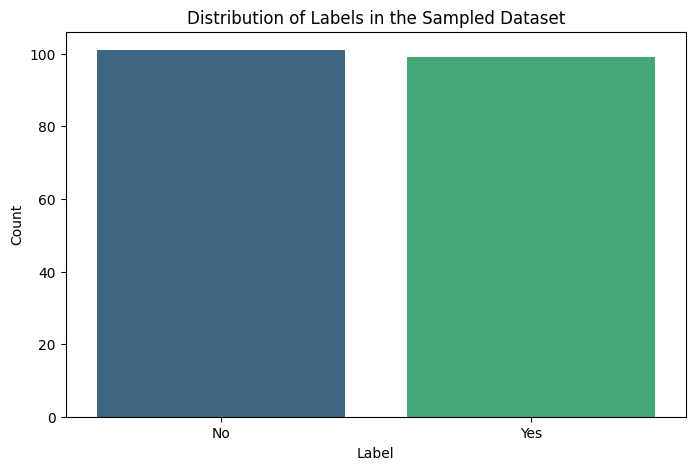

In [6]:
# Visualize the distribution of the true labels
plt.figure(figsize=(8, 5))
sns.countplot(x='true_label', data=df_processed, palette='viridis')
plt.title('Distribution of Labels in the Sampled Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

#4. Building the Zero-Shot Classification Pipeline
We'll initialize a zero-shot-classification pipeline from the transformers library. This pipeline uses a model pre-trained on Natural Language Inference (NLI), which is excellent at determining if a "premise" (our sentence) logically entails a "hypothesis" (our candidate labels).

We'll use a popular and effective model for this task: facebook/bart-large-mnli.

In [18]:
# Initialize the zero-shot classification pipeline
# We specify the model and the device. Using GPU (device=0) is much faster.
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli",
                      device=0) # Use 0 for GPU, -1 for CPU

Device set to use cuda:0


Now, we define our candidate labels. The choice of labels is crucial in zero-shot learning as it directly impacts performance. The labels should be clear and directly relate to the task. We'll use the same labels as the dataset for a straightforward evaluation.

In [8]:
# Define the candidate labels for our classification task
candidate_labels = ["anachronistic", "not anachronistic"]

#5. Running Inference and Getting Predictions
With our pipeline ready, we can now feed it our sentences. We'll iterate through our processed DataFrame and get a prediction for each sentence. The pipeline returns a dictionary with labels and their corresponding confidence scores. We'll consider the label with the highest score as the model's prediction.

In [9]:
# This cell should now run without errors

# We'll store the predictions in a list
predictions = []

# Use tqdm for a progress bar as this step can take a few minutes
for sentence in tqdm(df_processed['sentence']):
    # The pipeline takes the sentence and the candidate labels
    result = classifier(sentence, candidate_labels)
    # We append the label with the highest score to our predictions list
    predictions.append(result['labels'][0])

# Add the predictions to our DataFrame
df_processed['predicted_label'] = predictions

print("\nInference complete. Here's a look at the results:")
df_processed[['sentence', 'true_label', 'predicted_label']].head(10)

  0%|          | 0/200 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Inference complete. Here's a look at the results:


,sentence,true_label,predicted_label
102,Pharoah Thutmose III successfully expanded the...,No,not anachronistic
179,Pharoah Thutmose III successfully expanded the...,Yes,not anachronistic
92,"Johann Sebastian Bach wrote the book ""Mathemat...",No,not anachronistic
14,Thomas Jefferson enjoyed honeycrisp apples on ...,Yes,not anachronistic
106,The woman and the wooly mammoth happily played...,No,not anachronistic
71,President Syngman Rhee sent a letter commendin...,No,anachronistic
20,Joan of Arc achieved martyrdom by defeating a ...,Yes,not anachronistic
102,Pharoah Thutmose III successfully expanded the...,No,not anachronistic
121,The winner of the first ever F1 World Champion...,Yes,not anachronistic
74,The first ever movie in color depicted the lif...,Yes,anachronistic


#6. Evaluating the Model.
Now that we have the model's predictions, let's evaluate its performance. We'll compare the true_label with the predicted_label using standard classification metrics and a confusion matrix.

Classification Metrics
The classification_report from scikit-learn gives us a nice summary of precision, recall, and F1-score for each class, along with the overall accuracy.

In [12]:
# Create a mapping dictionary
label_map = {
    'Yes': 'anachronistic',
    'No': 'not anachronistic'
}

# Apply the mapping to the true_label column
df_processed['true_label'] = df_processed['true_label'].map(label_map)

# Verify the change
print("Labels have been harmonized. New label distribution:")
print(df_processed['true_label'].value_counts())

Labels have been harmonized. New label distribution:
true_label
not anachronistic    101
anachronistic         99
Name: count, dtype: int64


In [13]:
# Generate the classification report
report = classification_report(df_processed['true_label'], df_processed['predicted_label'])
print("Classification Report:\n")
print(report)

Classification Report:

                   precision    recall  f1-score   support

    anachronistic       0.46      0.16      0.24        99
not anachronistic       0.50      0.81      0.62       101

         accuracy                           0.49       200
        macro avg       0.48      0.49      0.43       200
     weighted avg       0.48      0.49      0.43       200



#Confusion Matrix
A confusion matrix is a great way to visualize the model's performance. It shows us exactly where the model is getting confused. The diagonal elements represent correct predictions, while off-diagonal elements are errors.

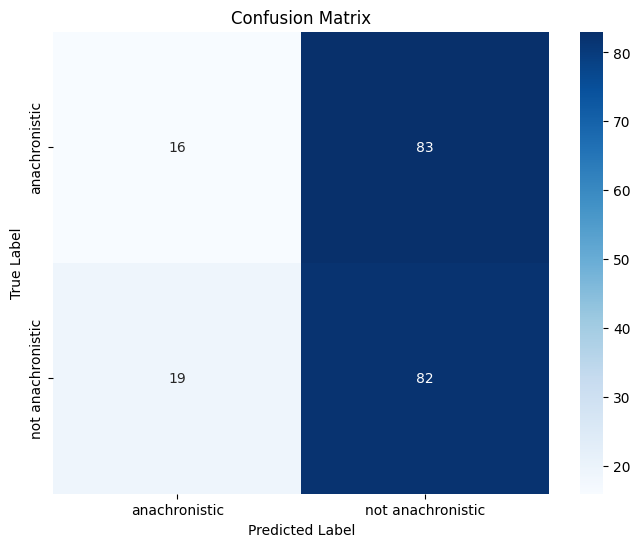

In [14]:
# Generate the confusion matrix
cm = confusion_matrix(df_processed['true_label'], df_processed['predicted_label'], labels=candidate_labels)

# Plot the confusion matrix using a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=candidate_labels, yticklabels=candidate_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
# Option A: More descriptive labels
candidate_labels = ["this sentence contains a historical error", "this sentence is historically accurate"]

# Option B: A different phrasing
# candidate_labels = ["out of place in time", "temporally consistent"]

# --- Then, rerun your inference loop ---
predictions = []
for sentence in tqdm(df_processed['sentence']):
    result = classifier(sentence, candidate_labels)
    predictions.append(result['labels'][0])

df_processed['predicted_label'] = predictions

# --- And map your true labels accordingly ---
label_map = {
    'anachronistic': "this sentence contains a historical error",
    'not anachronistic': "this sentence is historically accurate"
}
df_processed['true_label_mapped'] = df_processed['true_label'].map(label_map)

# --- Finally, rerun the classification report ---
# Make sure to compare the mapped true labels to the predictions
report = classification_report(df_processed['true_label_mapped'], df_processed['predicted_label'])
print(report)

  0%|          | 0/200 [00:00<?, ?it/s]

                                           precision    recall  f1-score   support

this sentence contains a historical error       0.50      0.55      0.52        99
   this sentence is historically accurate       0.51      0.46      0.48       101

                                 accuracy                           0.50       200
                                macro avg       0.50      0.50      0.50       200
                             weighted avg       0.50      0.50      0.50       200

